In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from cmcrameri import cm
from matplotlib.colors import to_rgba, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import PchipInterpolator
from scipy.stats import gaussian_kde
from pqcd.utils import (
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat,
    weighted_quantile
    )
from plot_utils import (
    rcparams,
    x_pe,
    x_cn,
    y_mr,
    xlim_pe,
    ylim_pe,
    xlim_cn,
    ylim_cn,
    xlim_mr,
    ylim_mr,
    xlim_mtov,
    prior_c,
    astro_c,
    gp0_pqcd_c,
    gp0_pqcd_ls,
    gp0_astro_pqcd_max_c,
    gp0_astro_pqcd_max_ls,
    gp0_astro_pqcd_mod_c,
    gp0_astro_pqcd_mod_ls,
    prior_kwargs,
    astro_hist_kwargs,
    astro_fill_kwargs,
    astro_line_kwargs,
    gp0_pqcd_kwargs,
    gp0_astro_pqcd_max_hist_kwargs,
    gp0_astro_pqcd_max_kwargs,
    gp0_astro_pqcd_mod_hist_kwargs,
    gp0_astro_pqcd_mod_kwargs
)
plt.rcParams.update(rcparams)

invalid_alpha = 0

In [2]:
rng = np.random.default_rng()

# GP0

In [3]:
# Collated EOSs
collated_eos_gp0 = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default.csv',
    index_col='eos'
)

# Quantities at nTOV
ntov_gp0 = to_nucleons_per_cubic_femtometre(collated_eos_gp0['ntov'])
ptov_gp0 = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/pressure_ntov.dat'
)
etov_gp0 = np.loadtxt(
    '../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat'
)

# Weights
astro_weights_gp0 = np.exp(
    collated_eos_gp0.logweight_total - collated_eos_gp0.logweight_total.max()
).values
ntov_max_weights_gp0 = np.loadtxt(
    '../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_Xmarg_mu2.6.dat'
)
ntov_marg_weights_gp0 = np.loadtxt(
    '../data/eos-draws-default/pqcd-weights/pqcd_weights_ntov_marg.dat'
)

In [4]:
# Nonzero astro
collated_eos_nonzero_astro = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default-nonzero-astro.csv',
    index_col='eos'
)

nonzero_astro_ntov_kde = gaussian_kde(
    to_nucleons_per_cubic_femtometre(collated_eos_nonzero_astro['ntov'])/nsat,
    bw_method=0.4
)

In [5]:
etov_gp0_nonzero_astro = etov_gp0[collated_eos_gp0.logweight_total > -np.inf]
ptov_gp0_nonzero_astro = ptov_gp0[collated_eos_gp0.logweight_total > -np.inf]

mask = ~np.logical_or(
    np.isnan(etov_gp0_nonzero_astro), np.isnan(ptov_gp0_nonzero_astro)
)
etov_gp0_nonzero_astro = etov_gp0_nonzero_astro[mask]
ptov_gp0_nonzero_astro = ptov_gp0_nonzero_astro[mask]

sample = rng.choice(len(etov_gp0_nonzero_astro), size=5000, replace=False)
etov_gp0_nonzero_astro = etov_gp0_nonzero_astro[sample]
ptov_gp0_nonzero_astro = ptov_gp0_nonzero_astro[sample]

In [6]:
ntov_median = np.median(
    to_nucleons_per_cubic_femtometre(collated_eos_nonzero_astro['ntov'])
)

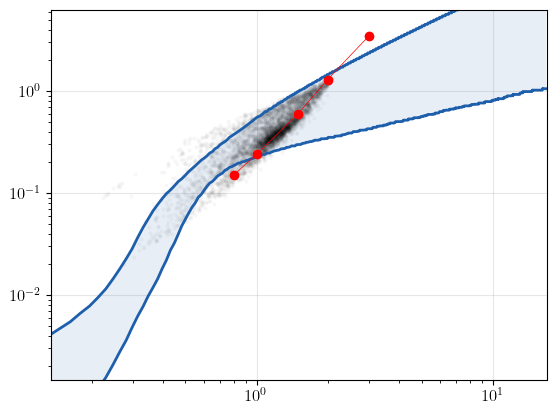

In [7]:
fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

ax.set_xscale('log')
ax.set_yscale('log')

# Astro-only
# ----------

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
)

ax.fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
ax.plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
ax.plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# p vs epsilon at nTOV
# --------------------

ax.plot(
    etov_gp0_nonzero_astro, 
    ptov_gp0_nonzero_astro, 
    lw=0, 
    c='k', 
    marker='.', 
    alpha=0.03, 
    markeredgewidth=0,
    zorder=0.9
)

# ---

x_fit = [0.8, 1, 1.5, 2, 3]
y_fit = [0.15, 0.24, 0.6, 1.3, 3.5]

ax.plot(x_fit, y_fit, lw=0.5, marker='o', c='r')

# ---

ax.set_xlim(xlim_pe)
ax.set_ylim(ylim_pe);

In [8]:
x_fit_dense = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense = PchipInterpolator(x_fit, y_fit)(x_fit_dense)
y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

In [9]:
x_fit = [1.45, 1.51, 1.53, 1.56, 1.64, 1.81, 2.0, 2.5, 2.9, 3.8, 5.9]
y_fit = [ylim_pe[0], 3e-3, 2e-2, 1e-1, 2.5e-1, 5e-1, 8e-1, 1.5, 2, 3, 5]

x_fit_dense_10nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_10nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_10nsat)
y_fit_interp_10nsat = np.interp(x_pe, x_fit_dense_10nsat, y_fit_dense_10nsat, left=-100)

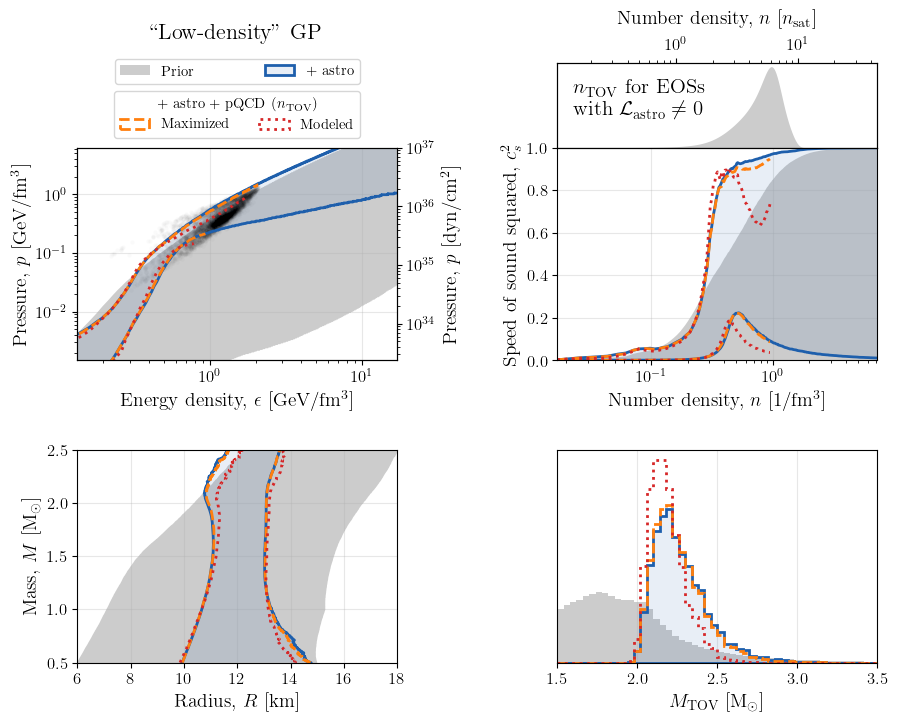

In [10]:
fig_width = 8
fig_height = 6

beta = 0.4

fig = plt.figure(figsize=(fig_width, fig_height))

main_grid = fig.add_gridspec(
    2, 2, top=1, bottom=0, left=0, right=1, height_ratios=[beta+1, 1], hspace=0.35, wspace=0.5
)

sub_grid_1 = main_grid[0, 0].subgridspec(2, 1, hspace=0, height_ratios=[beta, 1])
ax0 = fig.add_subplot(sub_grid_1[1, 0])

sub_grid_2 = main_grid[0, 1].subgridspec(2, 1, hspace=0, height_ratios=[beta, 1])
ax1 = fig.add_subplot(sub_grid_2[0, 0])
ax2 = fig.add_subplot(sub_grid_2[1, 0])

ax3 = fig.add_subplot(main_grid[1, 0])
ax4 = fig.add_subplot(main_grid[1, 1])

ax1.set_xticks([])
ax1.set_yticks([])
ax4.set_yticks([])

for ax in [ax0, ax2, ax3, ax4]:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

ax0.set_xscale('log')
ax0.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')

# Prior
# -----

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

ax0.fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_prior.csv'
)

ax2.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_prior.csv'
)

ax3.fill_betweenx(
    y_mr, 
    astro_quantiles_mr.loc[5,:].values, 
    astro_quantiles_mr.loc[95,:].values, 
    **prior_kwargs
)

# ---

ax4.hist(
    collated_eos_gp0['Mmax'],
    bins=50, 
    density=True,
    range=xlim_mtov,
    **prior_kwargs
)

# Astro-only
# ----------

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
)

ax0.fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
ax0.plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
ax0.plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro.csv'
)

ax2.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
ax2.plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
ax2.plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro.csv'
)

ax3.fill_betweenx(
    y_mr, 
    astro_quantiles_mr.loc[5,:].values,
    astro_quantiles_mr.loc[95,:].values,
    **astro_fill_kwargs
)
ax3.plot(astro_quantiles_mr.loc[5,:].values, y_mr, **astro_line_kwargs)
ax3.plot(astro_quantiles_mr.loc[95,:].values, y_mr, **astro_line_kwargs)

# ---

ax4.hist(
    collated_eos_gp0['Mmax'],
    weights=astro_weights_gp0,
    bins=50, 
    density=True,
    range=xlim_mtov,
    **astro_hist_kwargs
)

# Astro + pQCD (max, nTOV)
# ------------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

ax0.plot(x_pe[:i1], q5[:i1], **gp0_astro_pqcd_max_kwargs)
ax0.plot(x_pe[:i2], q95[:i2], **gp0_astro_pqcd_max_kwargs)

ax0.plot(x_pe[i1:], q5[i1:], **gp0_astro_pqcd_max_kwargs, alpha=invalid_alpha)
ax0.plot(x_pe[i2:], q95[i2:], **gp0_astro_pqcd_max_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

ax2.plot(x_cn[mask], q5[mask], **gp0_astro_pqcd_max_kwargs)
ax2.plot(x_cn[mask], q95[mask], **gp0_astro_pqcd_max_kwargs)

ax2.plot(x_cn[~mask], q5[~mask], **gp0_astro_pqcd_max_kwargs, alpha=invalid_alpha)
ax2.plot(x_cn[~mask], q95[~mask], **gp0_astro_pqcd_max_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

ax3.plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **gp0_astro_pqcd_max_kwargs)
ax3.plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **gp0_astro_pqcd_max_kwargs)

# ---

ax4.hist(
    collated_eos_gp0['Mmax'],
    weights=astro_weights_gp0*ntov_max_weights_gp0,
    bins=50, 
    density=True,
    range=xlim_mtov,
    **gp0_astro_pqcd_max_hist_kwargs
)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

ax0.plot(x_pe[:i1], q5[:i1], **gp0_astro_pqcd_mod_kwargs)
ax0.plot(x_pe[:i2], q95[:i2], **gp0_astro_pqcd_mod_kwargs)

ax0.plot(x_pe[i1:], q5[i1:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)
ax0.plot(x_pe[i2:], q95[i2:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

ax2.plot(x_cn[mask], q5[mask], **gp0_astro_pqcd_mod_kwargs)
ax2.plot(x_cn[mask], q95[mask], **gp0_astro_pqcd_mod_kwargs)

ax2.plot(x_cn[~mask], q5[~mask], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)
ax2.plot(x_cn[~mask], q95[~mask], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

ax3.plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **gp0_astro_pqcd_mod_kwargs)
ax3.plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **gp0_astro_pqcd_mod_kwargs)

# ---

ax4.hist(
    collated_eos_gp0['Mmax'],
    weights=astro_weights_gp0*ntov_marg_weights_gp0,
    bins=50, 
    density=True,
    range=(1.5, 3.5),
    **gp0_astro_pqcd_mod_hist_kwargs
)

# p vs epsilon at nTOV
# --------------------

ax0.plot(
    etov_gp0_nonzero_astro, 
    ptov_gp0_nonzero_astro, 
    lw=0, 
    c='k', 
    marker='.', 
    alpha=0.02, 
    markeredgewidth=0,
    zorder=0.9
)

# nTOV posterior
# --------------

ax1.fill_between(x_cn, 0, nonzero_astro_ntov_kde(x_cn/nsat), **prior_kwargs)
ax1.text(
    0.05, 
    0.8, 
    '$n_\\mathrm{TOV}$ for EOSs\nwith $\\mathcal{L}_\\mathrm{astro} \\neq 0$', 
    ha='left',
    va='top',
    transform=ax1.transAxes, 
    fontsize=15
)

# pressure vs energy density inset
# --------------------------------

# axins_lw = 1.5

# axins = inset_axes(
#     ax0, 
#     width="42%", 
#     height="37%", 
#     loc='lower right', 
#     borderpad=1.6
#     )

# axins.set_yscale('log')

# axins.set_axisbelow(True)
# axins.grid(alpha=0.3)

# axins.tick_params(labelsize=9)

# prior_quantiles_pe = to_GeV_per_cubic_femtometre(
#     pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
# )

# axins.fill_between(
#     x_pe,
#     prior_quantiles_pe.loc[5,:].values,
#     prior_quantiles_pe.loc[95,:].values,
#     **prior_kwargs
# )

# astro_quantiles_pe = to_GeV_per_cubic_femtometre(
#     pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
# )

# axins.fill_between(
#     x_pe,
#     astro_quantiles_pe.loc[5,:].values,
#     astro_quantiles_pe.loc[95,:].values,
#     **astro_fill_kwargs
# )

# axins.plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
# axins.plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
#     pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv')
# )

# q5 = pqcd_quantiles_pe.loc[5,:].values
# q95 = pqcd_quantiles_pe.loc[95,:].values

# i1 = np.argmin((q5 - y_fit_interp)**2)
# i2 = np.argmin((q95 - y_fit_interp)**2)

# axins.plot(x_pe[:i1], q5[:i1], **gp0_astro_pqcd_max_kwargs)
# axins.plot(x_pe[:i2], q95[:i2], **gp0_astro_pqcd_max_kwargs)

# axins.plot(x_pe[i1:], q5[i1:], **gp0_astro_pqcd_max_kwargs, alpha=invalid_alpha)
# axins.plot(x_pe[i2:], q95[i2:], **gp0_astro_pqcd_max_kwargs, alpha=invalid_alpha)

# pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
#     pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
# )

# q5 = pqcd_quantiles_pe.loc[5,:].values
# q95 = pqcd_quantiles_pe.loc[95,:].values

# i1 = np.argmin((q5 - y_fit_interp)**2)
# i2 = np.argmin((q95 - y_fit_interp)**2)

# axins.plot(x_pe[:i1], q5[:i1], **gp0_astro_pqcd_mod_kwargs)
# axins.plot(x_pe[:i2], q95[:i2], **gp0_astro_pqcd_mod_kwargs)

# axins.plot(x_pe[i1:], q5[i1:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)
# axins.plot(x_pe[i2:], q95[i2:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)

# axins.set_xlim((xlim_pe[0], 2.0))
# axins.set_ylim(1e-2, 2)

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(to_rgba(astro_c))[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    ),
]
custom_labels = ['Prior', '+ astro']

l1 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='upper center', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(0.5,1.45),
    columnspacing=4.9
)
ax0.add_artist(l1)

custom_handles = [
    mpatches.Patch(fill=None, edgecolor=gp0_astro_pqcd_max_c, lw=2, ls=gp0_astro_pqcd_max_ls),
    mpatches.Patch(fill=None, edgecolor=gp0_astro_pqcd_mod_c, lw=2, ls=gp0_astro_pqcd_mod_ls),
]
custom_labels = ['Maximized', 'Modeled']

l2 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='upper center', 
    ncol=2,
    fontsize=10.5, 
    title_fontsize=10.5,
    title='+ astro + pQCD ($n_\mathrm{TOV}$)',
    bbox_to_anchor=(0.5,1.3),
)

# ---

ax0.set_xlim(xlim_pe)
ax0.set_ylim(ylim_pe)

ax1.set_xlim(xlim_cn)
ax1.set_ylim(0)

ax2.set_xlim(xlim_cn)
ax2.set_ylim(ylim_cn)

ax3.set_xlim(xlim_mr)
ax3.set_ylim(ylim_mr)

ax4.set_xlim(xlim_mtov)
ax4.set_ylim(0)

# ---

twinx = ax0.twinx()
twinx.set_yscale('log')
twinx.set_ylim(
    GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax0.get_ylim()))
)
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = ax1.twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(ax1.get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

ax1.set_xticks([])

# ---

ax0.text(
    0.5, 
    1.51, 
    "``Low-density'' GP",
    ha='center',
    transform=ax0.transAxes, 
    fontsize=16
)

ax0.set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
ax0.set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

ax2.set_xlabel('Number density, $n$ [1/fm$^3$]')
ax2.set_ylabel('Speed of sound squared, $c_s^2$')

ax3.set_xlabel(r'Radius, $R$ [km]')
ax3.set_ylabel(r'Mass, $M$ [M${}_\odot$]')

ax4.set_xlabel(r'$M_\mathrm{TOV}$ [M${}_\odot$]')

# ---

fig.savefig('figures/paper/astro_pqcd_gp0_posterior.pdf', bbox_inches='tight')

In [11]:
astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro.csv'
)
q5 = astro_quantiles_mr.loc[5,:].values
q50 = astro_quantiles_mr.loc[50,:].values
q95 = astro_quantiles_mr.loc[95,:].values

index = np.argmin(np.abs(y_mr - 2))
print(f'{q50[index]:.2f} + {q95[index]-q50[index]:.2f} - {q50[index]-q5[index]:.2f}')

12.07 + 1.02 - 1.20


In [12]:
astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)
q5 = astro_quantiles_mr.loc[5,:].values
q50 = astro_quantiles_mr.loc[50,:].values
q95 = astro_quantiles_mr.loc[95,:].values

index = np.argmin(np.abs(y_mr - 2))
print(f'{q50[index]:.2f} + {q95[index]-q50[index]:.2f} - {q50[index]-q5[index]:.2f}')

12.35 + 0.85 - 1.08


In [13]:
q5, q50, q95 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantiles/r_of_m_quantiles_astro.dat'
)
index = np.argmin(np.abs(y_mr - 2))
print(f'{q50[index]:.2f} + {q95[index]-q50[index]:.2f} - {q50[index]-q5[index]:.2f}')

12.17 + 1.03 - 1.07


In [14]:
q5, q50, q95 = weighted_quantile(
    collated_eos_gp0['Mmax'].values,
    (0.05, 0.5, 0.95),
    astro_weights_gp0
)
print(f'GP0: 5th, 50th, 95th percentiles: {q5}, {q50}, {q95}')
print(f'{q50:.2f} + {q95-q50:.2f} - {q50-q5:.2f}')

GP0: 5th, 50th, 95th percentiles: 2.0605543767048786, 2.2354573785255454, 2.6003573584153705
2.24 + 0.36 - 0.17


In [15]:
q5, q50, q95 = weighted_quantile(
    collated_eos_gp0['Mmax'].values,
    (0.05, 0.5, 0.95),
    astro_weights_gp0*ntov_marg_weights_gp0
)
print(f'GP0: 5th, 50th, 95th percentiles: {q5}, {q50}, {q95}')
print(f'{q50:.2f} + {q95-q50:.2f} - {q50-q5:.2f}')

GP0: 5th, 50th, 95th percentiles: 2.041470408560412, 2.167812356812661, 2.4014099589358717
2.17 + 0.23 - 0.13


# GP2

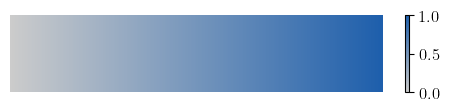

In [16]:
colors = [prior_c, astro_c]
gpn_cmap = LinearSegmentedColormap.from_list("gray_to_blue", colors)

# Display the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(6, 1))
plt.imshow(gradient, aspect="auto", cmap=gpn_cmap)
plt.colorbar()
plt.axis("off")
plt.show()

In [17]:
def rescale(weight, vmin=1e-5):
    if weight < vmin:
        return 0
    else:
        log_weight = np.log10(weight)
        return (log_weight-np.log10(vmin))/(0-np.log10(vmin))

In [18]:
collated_eos_gp2 = pd.read_csv(
    '../data/eos-draws-modified/gp2/eos-draws-modified-gp2.csv'
)

astro_weights_gp2 = np.exp(
    collated_eos_gp2.logweight_total - collated_eos_gp2.logweight_total.max()
).values
astro_weights_gp2 /= max(astro_weights_gp2)

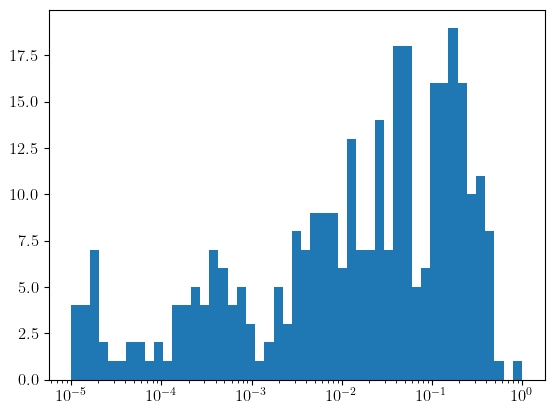

In [19]:
l = 10000
number = 1000

gp2_astro_weights_sample = astro_weights_gp2[l:l+number]
gp2_astro_weights_sample /= max(gp2_astro_weights_sample)

fig, ax = plt.subplots()
bins = np.logspace(-5, 0, 50)
ax.hist(gp2_astro_weights_sample, bins=bins)
ax.set_xscale('log')

In [20]:
ntov_gp2 = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantities_at_n/density_ntov.dat',
)

ntov_q5, ntov_q50, ntov_q95 = weighted_quantile(
    ntov_gp2,
    quantiles=[0.05, 0.5, 0.95],
    weights=astro_weights_gp2
)

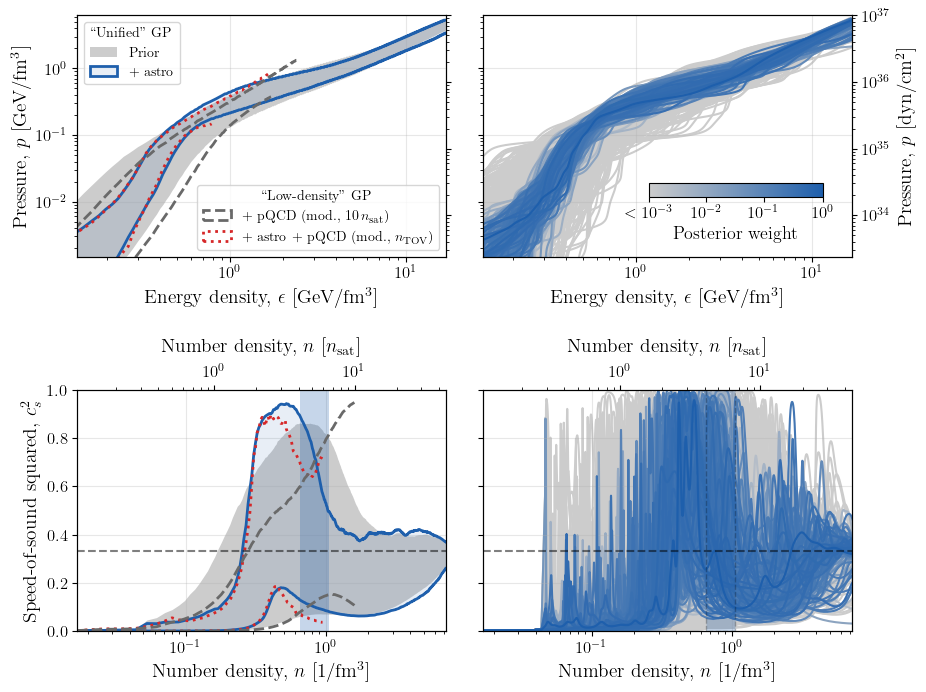

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.55, wspace=0.1)

for ax in axs.flatten():
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)


axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[1][0].set_xscale('log')

axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')
axs[1][1].set_xscale('log')

# Prior
# -----

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0][0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# Astro-only
# ----------

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0][0].fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **gp0_astro_pqcd_mod_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **gp0_astro_pqcd_mod_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1][0].plot(x_cn[mask], q5[mask], **gp0_astro_pqcd_mod_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **gp0_astro_pqcd_mod_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)

# pQCD only (marg, nTOV)
# ----------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp_10nsat)**2)
i2 = np.argmin((q95 - y_fit_interp_10nsat)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **gp0_pqcd_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **gp0_pqcd_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **gp0_pqcd_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **gp0_pqcd_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_pqcd_10nsat_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < 10*nsat

axs[1][0].plot(x_cn[mask], q5[mask], **gp0_pqcd_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **gp0_pqcd_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **gp0_pqcd_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **gp0_pqcd_kwargs, alpha=invalid_alpha)

# ---

for i, n in enumerate(collated_eos_gp2.eos.iloc[l:l+number]):

    df = pd.read_csv(
        f'../data/eos-draws-modified/gp2/margagn/DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    weight = rescale(gp2_astro_weights_sample[i], vmin=1e-3)

    if weight < 1e-2:
        rasterized = True
    else:
        rasterized = False

    axs[0][1].plot(
        energy_density,
        pressure,
        c=gpn_cmap(weight),
        zorder=weight,
        rasterized=rasterized
    )

    axs[1][1].plot(
        number_density,
        speed_of_sound_squared,
        c=gpn_cmap(weight),
        zorder=weight,
        rasterized=rasterized
    )

# ---

axs[0][0].set_xlim(xlim_pe)
axs[0][0].set_ylim(ylim_pe)

axs[1][0].set_xlim(xlim_cn)
axs[1][0].set_ylim(ylim_cn)

axs[0][1].set_xlim(xlim_pe)
axs[0][1].set_ylim(ylim_pe)

axs[1][1].set_xlim(xlim_cn)
axs[1][1].set_ylim(ylim_cn)

# ---

twinx = axs[0][0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][0].get_ylim())))
twinx.set_yticklabels([])

twinx = axs[0][1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1][0].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][0].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

twiny = axs[1][1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

for ax in axs[1,:]:
    ax.axhline(1/3, c='k', ls='--', alpha=0.5)

axs[1,0].fill_betweenx(
    [0,1], 
    ntov_q5, 
    ntov_q95, 
    color=astro_c,
    alpha=0.25,
    linewidth=0
)

axs[1,1].fill_betweenx(
    [0,1], 
    ntov_q5, 
    ntov_q95, 
    color=astro_c,
    alpha=0.25,
    edgecolor='k',
    linestyle='--',
    linewidth=1.0
)


# ---

axs[0][1].set_yticklabels([])
axs[1][1].set_yticklabels([])

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(to_rgba(astro_c))[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', '+ astro']

l1 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='upper left', 
    ncol=1,
    title_fontsize=10,
    title="``Unified'' GP",
    fontsize=10,
)
axs[0][0].add_artist(l1)

custom_handles = [
    mpatches.Patch(fill=None, edgecolor=gp0_pqcd_c, lw=2, ls=gp0_pqcd_ls),
    mpatches.Patch(fill=None, edgecolor=gp0_astro_pqcd_mod_c, lw=2, ls=gp0_astro_pqcd_mod_ls),
]
custom_labels = [
    '+ pQCD (mod., $10\,n_\mathrm{sat}$)',
    '+ astro + pQCD (mod., $n_\mathrm{TOV}$)'
]

l2 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=1,
    title_fontsize=10,
    title="``Low-density'' GP",
    fontsize=10
)

# ---

cbaxes = axs[0][1].inset_axes(
    [0.45, 0.25, 0.47, 0.055]
    ) 
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(cmap=gpn_cmap),
    cax=cbaxes, 
    ticks=[0, 0.33, 0.66, 1],
    orientation='horizontal',
    )
cbar1.set_ticklabels(['$< 10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
cbar1.set_label('Posterior weight', size=13)

# ---

axs[0][0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0][0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1][0].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1][0].set_ylabel('Speed-of-sound squared, $c_s^2$')

axs[1][1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[0][1].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')

fig.savefig('figures/paper/astro_pqcd_gp2_posterior.pdf', bbox_inches='tight', dpi=300)

# GP1

In [22]:
collated_eos_gp1 = pd.read_csv(
    '../data/eos-draws-modified/gp1/eos-draws-modified-gp1.csv'
)

astro_weights_gp1 = np.exp(
    collated_eos_gp1.logweight_total - collated_eos_gp1.logweight_total.max()
).values
astro_weights_gp1 /= max(astro_weights_gp1)

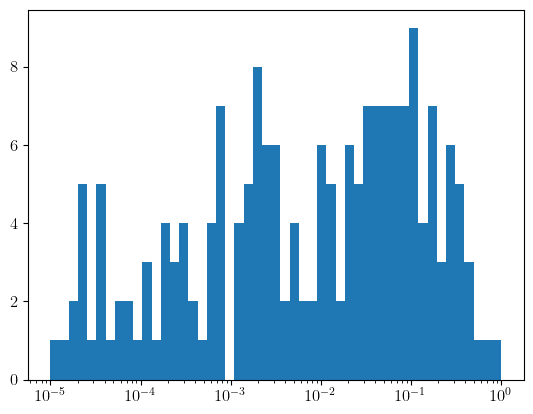

In [23]:
l = 25000
number = 1000

gp1_astro_weights_sample = astro_weights_gp1[l:l+number]
gp1_astro_weights_sample /= max(gp1_astro_weights_sample)

fig, ax = plt.subplots()
bins = np.logspace(-5, 0, 50)
ax.hist(gp1_astro_weights_sample, bins=bins)
ax.set_xscale('log')

In [24]:
ntov_gp1 = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantities_at_n/density_ntov.dat',
)

ntov_q5_gp1, ntov_q50_gp1, ntov_q95_gp1 = weighted_quantile(
    ntov_gp1,
    quantiles=[0.05, 0.5, 0.95],
    weights=astro_weights_gp1
)

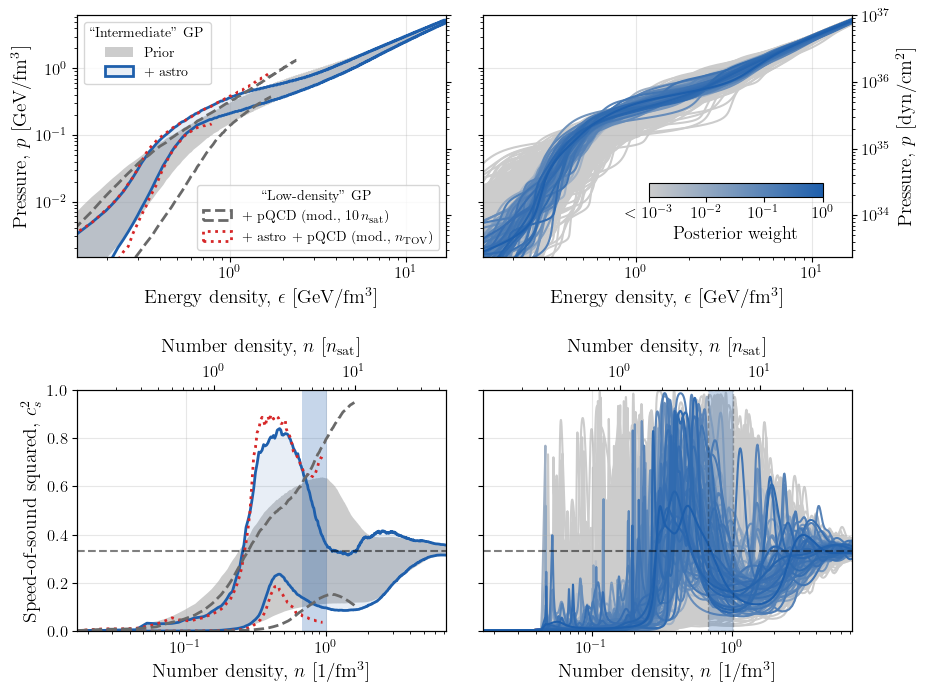

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.55, wspace=0.1)

for ax in axs.flatten():
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)


axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[1][0].set_xscale('log')

axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')
axs[1][1].set_xscale('log')

# Prior
# -----

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0][0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# Astro-only
# ----------

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0][0].fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **gp0_astro_pqcd_mod_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **gp0_astro_pqcd_mod_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1][0].plot(x_cn[mask], q5[mask], **gp0_astro_pqcd_mod_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **gp0_astro_pqcd_mod_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **gp0_astro_pqcd_mod_kwargs, alpha=invalid_alpha)

# pQCD only (marg, nTOV)
# ----------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp_10nsat)**2)
i2 = np.argmin((q95 - y_fit_interp_10nsat)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **gp0_pqcd_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **gp0_pqcd_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **gp0_pqcd_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **gp0_pqcd_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_pqcd_10nsat_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < 10*nsat

axs[1][0].plot(x_cn[mask], q5[mask], **gp0_pqcd_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **gp0_pqcd_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **gp0_pqcd_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **gp0_pqcd_kwargs, alpha=invalid_alpha)

# ---

for i, n in enumerate(collated_eos_gp1.eos.iloc[l:l+number]):

    df = pd.read_csv(
        f'../data/eos-draws-modified/gp1/margagn/DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    weight = rescale(gp1_astro_weights_sample[i], vmin=1e-3)

    if weight < 1e-2:
        rasterized = True
    else:
        rasterized = False

    axs[0][1].plot(
        energy_density,
        pressure,
        c=gpn_cmap(weight),
        zorder=weight,
        rasterized=rasterized
    )

    axs[1][1].plot(
        number_density,
        speed_of_sound_squared,
        c=gpn_cmap(weight),
        zorder=weight,
        rasterized=rasterized
    )

# ---

axs[0][0].set_xlim(xlim_pe)
axs[0][0].set_ylim(ylim_pe)

axs[1][0].set_xlim(xlim_cn)
axs[1][0].set_ylim(ylim_cn)

axs[0][1].set_xlim(xlim_pe)
axs[0][1].set_ylim(ylim_pe)

axs[1][1].set_xlim(xlim_cn)
axs[1][1].set_ylim(ylim_cn)

# ---

twinx = axs[0][0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][0].get_ylim())))
twinx.set_yticklabels([])

twinx = axs[0][1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1][0].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][0].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

twiny = axs[1][1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

for ax in axs[1,:]:
    ax.axhline(1/3, c='k', ls='--', alpha=0.5)

axs[1,0].fill_betweenx(
    [0,1], 
    ntov_q5_gp1, 
    ntov_q95_gp1, 
    color=astro_c,
    alpha=0.25,
    linewidth=0
)

axs[1,1].fill_betweenx(
    [0,1], 
    ntov_q5_gp1, 
    ntov_q95_gp1, 
    color=astro_c,
    alpha=0.25,
    edgecolor='k',
    linestyle='--',
    linewidth=1.0
)

# ---

axs[0][1].set_yticklabels([])
axs[1][1].set_yticklabels([])

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(to_rgba(astro_c))[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', '+ astro']

l1 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='upper left', 
    ncol=1,
    title_fontsize=10,
    title="``Intermediate'' GP",
    fontsize=10,
)
axs[0][0].add_artist(l1)

custom_handles = [
    mpatches.Patch(fill=None, edgecolor=gp0_pqcd_c, lw=2, ls=gp0_pqcd_ls),
    mpatches.Patch(fill=None, edgecolor=gp0_astro_pqcd_mod_c, lw=2, ls=gp0_astro_pqcd_mod_ls),
]
custom_labels = [
    '+ pQCD (mod., $10\,n_\mathrm{sat}$)',
    '+ astro + pQCD (mod., $n_\mathrm{TOV}$)'
]

l2 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=1,
    title_fontsize=10,
    title="``Low-density'' GP",
    fontsize=10
)

# ---

cbaxes = axs[0][1].inset_axes(
    [0.45, 0.25, 0.47, 0.055]
    ) 
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(cmap=gpn_cmap),
    cax=cbaxes, 
    ticks=[0, 0.33, 0.66, 1],
    orientation='horizontal',
    )
cbar1.set_ticklabels(['$< 10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
cbar1.set_label('Posterior weight', size=13)

# ---

axs[0][0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0][0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1][0].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1][0].set_ylabel('Speed-of-sound squared, $c_s^2$')

axs[1][1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[0][1].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')

fig.savefig('figures/paper/astro_pqcd_gp1_posterior.pdf', bbox_inches='tight', dpi=300)